In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import os
import pathlib
from glob import glob
from astropy.table import Table, unique
from scipy.fft import fft, ifft
from IPython.display import display, Math, Markdown
from cmath import exp, pi
from astropy.io import ascii

os.chdir(pathlib.Path.cwd())
def set_rcparams():
    tab = Table.read('../../rcparams.txt', format='csv')
    for i in range(len(tab)):
        try:
            plt.rcParams[tab['key'][i]] = float(tab['val'][i])
        except ValueError:
            plt.rcParams[tab['key'][i]] = str(tab['val'][i])
    return
set_rcparams()
plt.style.use('dark_background')

In [3]:
def get_lightcurve(filelist, normalize = False):
    d, fl, err = [], [], []
    day_list = [(day['J.D.-2400000']-56999.915).tolist() for day in filelist]
    flux_list = [flux['rel_flux_T1'].tolist() for flux in filelist]
    fluxerr_list = [fluxerr['rel_flux_err_T1'].tolist() for fluxerr in filelist]
    for day, flux, error in zip(day_list, flux_list, fluxerr_list):
        d = d + day
        fl = fl + flux 
        err = err + error
    if normalize==True:
        return lk.LightCurve(time=d, flux=fl, flux_err=err).normalize()
    return lk.LightCurve(time=d, flux=fl, flux_err=err)

In [9]:
gp_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_gp*'))
gp_objs = [ascii.read(file) for file in gp_files]

remove = [0, 43, 1, 1, 0, 0]
[gp_objs[i] == gp_objs[i].sort(keys='rel_flux_T1') for i in range(len(gp_objs))]
for index, j in enumerate(remove):
    gp_objs[index] = gp_objs[index][j:]
gplc = get_lightcurve(gp_objs, False)

In [10]:
ip_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_ip*'))
ip_objs = [ascii.read(file) for file in ip_files]

remove = [0, 0, 0, 700, 0, 0]
[ip_objs[i].sort(keys='rel_flux_T1') for i in range(len(ip_objs))]
for index, j in enumerate(remove):
    ip_objs[index] = ip_objs[index][j:]

iplc = get_lightcurve(ip_objs, False)

In [11]:
rp_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_rp*.xls'))
rp_objs = [ascii.read(file) for file in rp_files]


remove = [0, 1, 1, 0, 0, 0]
[rp_objs[i].sort(keys='rel_flux_T1') for i in range(len(rp_objs))]
for index, j in enumerate(remove):
    rp_objs[index] = rp_objs[index][j:]
[rp_objs[i] == unique(rp_objs[i], keys='Label') for i in range(len(rp_objs))]

rplc = get_lightcurve(rp_objs, False)

In [12]:
zs_files = sorted(glob('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/muscat_zs_*.xls'))
zs_objs = [ascii.read(file) for file in zs_files]

remove = [0, 0, 12, 0, 0, 0]
[zs_objs[i].sort(keys='rel_flux_T1') for i in range(len(zs_objs))]
for index, j in enumerate(remove):
    zs_objs[index] = zs_objs[index][j:]
[zs_objs[i] == unique(zs_objs[i], keys='Label') for i in range(len(zs_objs))]

zslc = get_lightcurve(zs_objs, False)

In [ ]:
from turtle import st


stella_data = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/data_analysis/tess/stella_lc.csv')
stella_lc = lk.LightCurve(flux=stella_data['flux'], time=stella_data['time'], flux_err=stella_data['flux_err'])#.normalize()

with open('stella_probabilities.npy', 'rb') as f:
    avg_pred = np.load(f)

stella_lc.add_column(avg_pred, name='stella_prob'
                     )
stella_lc_og = stella_lc.copy()
x_og = np.ascontiguousarray(stella_lc_og.time.value, dtype=np.float64)
y_og = np.ascontiguousarray(stella_lc_og.flux, dtype=np.float64)
yerr_og_scaled = np.ascontiguousarray(stella_lc_og.flux_err * stella_lc_og['stella_prob'], dtype=np.float64)
yerr_og_not = np.ascontiguousarray(stella_lc_og.flux_err, dtype=np.float64)


(3882.7, 3889.0)

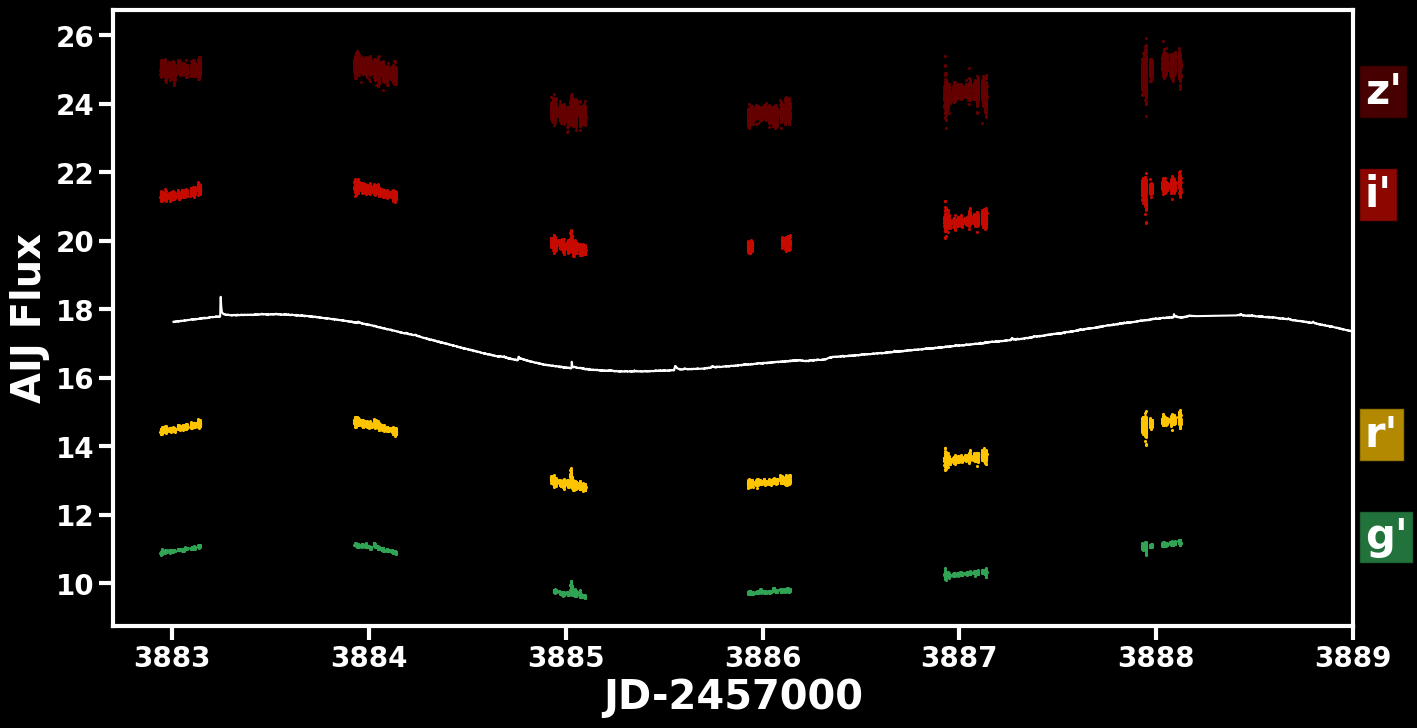

In [ ]:
afig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
ax.plot(x_og, y_og*17, color='w')

ax.scatter(zslc['time'].value, zslc['flux'], s=1.5, color="#640000")
ax.scatter(iplc['time'].value, iplc['flux'], s=1.5, color="#C70A00")
ax.scatter(rplc['time'].value, rplc['flux'], s=1.5, color="#FFC400")
ax.scatter(gplc['time'].value, gplc['flux'], s=1.5, color="#30A355")

ax.text(3889.06, 24, 'z\'', fontsize=30, c='w', bbox=dict(edgecolor='k', facecolor='#640000', alpha=0.7))
ax.text(3889.06, 21, 'i\'', fontsize=30, c='w', bbox=dict(edgecolor='k', facecolor='#C70A00', alpha=0.7))
ax.text(3889.06, 14, 'r\'', fontsize=30, c='w', bbox=dict(edgecolor='k', facecolor='#FFC400', alpha=0.7))
#ax.text(3885.3, 18,  'TESS (17x)', fontsize=15, c='k', bbox=dict(edgecolor='k', facecolor="#FFFFFF", alpha=0.7))
ax.text(3889.06, 11, 'g\'', fontsize=30, c='w', bbox=dict(edgecolor='k', facecolor='#30A355', alpha=0.7))

ax.set_ylabel('AIJ Flux')
ax.set_xlabel('JD-2457000')
ax.set_xlim(3882.7, 3889)

In [78]:
zslc_normed = get_lightcurve(zs_objs, True)
rplc_normed = get_lightcurve(rp_objs, True)
iplc_normed = get_lightcurve(ip_objs, True)
gplc_normed = get_lightcurve(gp_objs, True)

(3882.7, 3889.0)

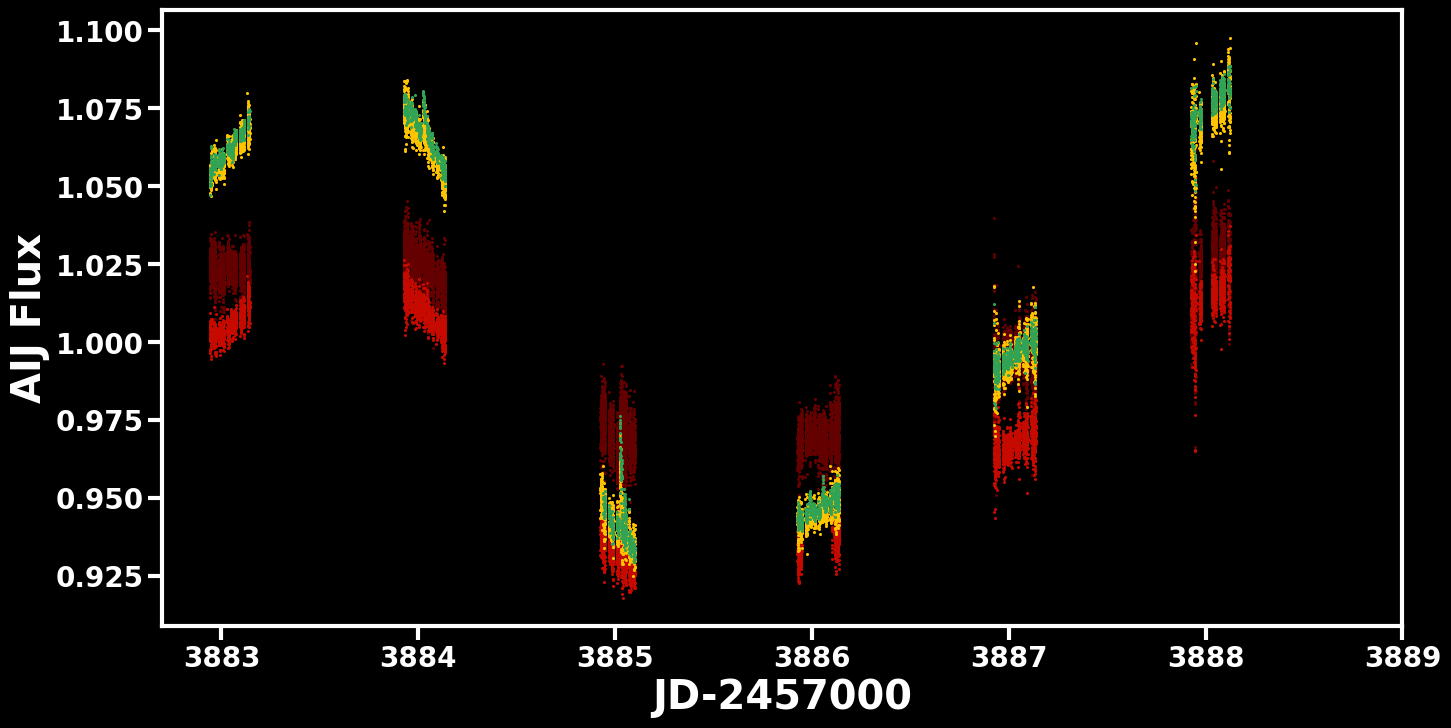

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16,8))
#ax.plot(x_og, y_og*17, color='w')

plt.scatter(ax=ax[0,0], x=zslc_normed['time'].value, y=zslc_normed['flux'], s=1.5, color="#640000")
plt.scatter(ax=ax[0,1], x=iplc_normed['time'].value, y=iplc_normed['flux'], s=1.5, color="#C70A00")
plt.scatter(ax=ax[1,0], x=rplc_normed['time'].value, y=rplc_normed['flux'], s=1.5, color="#FFC400")
plt.scatter(ax=ax[1,1], x=gplc_normed['time'].value, y=gplc_normed['flux'], s=1.5, color="#30A355")

ax.set_ylabel('AIJ Flux')
ax.set_xlabel('JD-2457000')
ax.set_xlim(3882.7, 3889)